>> ANAMOLY DETECTION - ELECTRICITY CONSUMPTION - REGRESSION APPROACH

>> Code written in Databricks. Titles that were provided for every command cell is not compatible/displayable in this Jupyter Notebook.

>> Anamoly detection using Forecasting is based on the approach where we make use of several data points from the past, to generate forecast for future with the addition of some impact features. 

>> We will make use of Regression Models to “forecast future Energy Consumption” (for every 15mins), which ushers the users to consume energy consciously and efficiently, in the future.

>> Author: Vijay Kailash S 

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
df1 = pd.read_csv("/dbfs/FileStore/shared_uploads/vijaykailash.sankaranaray@wipro.com/1__Consumable_Energy_Surge_Detection_Data___Train-1.csv")
df1.shape

(35134, 4)

In [0]:
df1.head(10)

,Date Time,Electricity Consumed [kWh],Unnamed: 2,Unnamed: 3
0,01-01-16 00:15,2.85,NaN,NaN
1,01-01-16 00:30,2.85,NaN,NaN
2,01-01-16 00:45,3.00,NaN,NaN
3,01-01-16 01:00,2.94,NaN,NaN
4,01-01-16 01:15,2.79,NaN,NaN
5,01-01-16 01:30,2.79,NaN,NaN
6,01-01-16 01:45,2.70,NaN,NaN
7,01-01-16 02:00,2.73,NaN,NaN
8,01-01-16 02:15,2.67,NaN,NaN
9,01-01-16 02:30,2.73,NaN,NaN


In [0]:
df1.isna().sum()

Date Time                         0
Electricity Consumed [kWh]        0
Unnamed: 2                    35134
Unnamed: 3                    35134
dtype: int64

In [0]:
df1=df1.drop(['Unnamed: 2','Unnamed: 3'],axis=1)

In [0]:
df1.head()

,Date Time,Electricity Consumed [kWh]
0,01-01-16 00:15,2.85
1,01-01-16 00:30,2.85
2,01-01-16 00:45,3.00
3,01-01-16 01:00,2.94
4,01-01-16 01:15,2.79


In [0]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35134 entries, 0 to 35133
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date Time                   35134 non-null  object 
 1   Electricity Consumed [kWh]  35134 non-null  float64
dtypes: float64(1), object(1)
memory usage: 549.1+ KB


In [0]:
df1['Timestamp']=pd.to_datetime(df1['Date Time'])

In [0]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35134 entries, 0 to 35133
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date Time                   35134 non-null  object        
 1   Electricity Consumed [kWh]  35134 non-null  float64       
 2   Timestamp                   35134 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 823.6+ KB


In [0]:

#df1 = df1.set_index('Date/Time')

df1.drop(['Date Time'],axis=1,inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35134 entries, 0 to 35133
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Electricity Consumed [kWh]  35134 non-null  float64       
 1   Timestamp                   35134 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 549.1 KB


In [0]:
df1['day'] = pd.DatetimeIndex(df1['Timestamp']).day
df1['month'] = pd.DatetimeIndex(df1['Timestamp']).month
df1['hour'] = pd.DatetimeIndex(df1['Timestamp']).hour
df1['minute'] = pd.DatetimeIndex(df1['Timestamp']).minute

df1['monthstart'] = pd.DatetimeIndex(df1['Timestamp']).is_month_start
df1['monthend'] = pd.DatetimeIndex(df1['Timestamp']).is_month_end
df1['dayofweek'] = pd.DatetimeIndex(df1['Timestamp']).dayofweek

df1['weekofyear'] = pd.DatetimeIndex(df1['Timestamp']).weekofyear
# https://en.wikipedia.org/wiki/ISO_week_date#First_week
df1['quarter'] = pd.DatetimeIndex(df1['Timestamp']).quarter

<command-1190536555879608>:10: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df1['weekofyear'] = pd.DatetimeIndex(df1['Timestamp']).weekofyear


In [0]:
df1.monthstart = df1.monthstart.replace({True: 1, False: 0})
df1.monthend = df1.monthend.replace({True: 1, False: 0})
df1

,Electricity Consumed [kWh],Timestamp,day,month,hour,minute,monthstart,monthend,dayofweek,weekofyear,quarter
0,2.85,2016-01-01 00:15:00,1,1,0,15,1,0,4,53,1
1,2.85,2016-01-01 00:30:00,1,1,0,30,1,0,4,53,1
2,3.00,2016-01-01 00:45:00,1,1,0,45,1,0,4,53,1
3,2.94,2016-01-01 01:00:00,1,1,1,0,1,0,4,53,1
4,2.79,2016-01-01 01:15:00,1,1,1,15,1,0,4,53,1
...,...,...,...,...,...,...,...,...,...,...,...
35129,2.43,2016-12-31 22:45:00,31,12,22,45,0,1,5,52,4
35130,2.43,2016-12-31 23:00:00,31,12,23,0,0,1,5,52,4
35131,2.40,2016-12-31 23:15:00,31,12,23,15,0,1,5,52,4
35132,2.43,2016-12-31 23:30:00,31,12,23,30,0,1,5,52,4


In [0]:
# Categorize the energy consumption based on weekdays and (weekends + holidays)
#1 Check for energy consumption on week days
#2 Check for energy consumption on (weekends + holidays in the calender year)

In [0]:
df1['weekend']=np.zeros(len(df1))
df1['weekend'] = df1['weekend'].astype('int64')

df1['weekend'][(df1['dayofweek']==5)|(df1['dayofweek']==6)]=1

<command-1190536555879492>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['weekend'][(df1['dayofweek']==5)|(df1['dayofweek']==6)]=1


In [0]:
#pip install holidays
#import datetime as dt
#import holidays

# get holiday calender
# for date,name in sorted(holidays.IND(years=2016).items()):
#   print(date,name)

#df1['holiday']=np.zeros(len(df1))
#df1['holiday'] = df1['holiday'].astype('int64')

#df1['holiday'][(df1['Timestamp']=='2016-01-14')|(df1['Timestamp']=='2016-01-26')|
#(df1['Timestamp']=='2016-03-20')|(df1['Timestamp']=='2016-03-24')|
#(df1['Timestamp']=='2016-03-25')|(df1['Timestamp']=='2016-03-27')|
#(df1['Timestamp']=='2016-05-01')|(df1['Timestamp']=='2016-05-15')|
#(df1['Timestamp']=='2016-07-07')|(df1['Timestamp']=='2016-08-15')|
#(df1['Timestamp']=='2016-09-11')|(df1['Timestamp']=='2016-10-02')|
#(df1['Timestamp']=='2016-10-11')|(df1['Timestamp']=='2016-10-30')|
#(df1['Timestamp']=='2016-12-11')|(df1['Timestamp']=='2016-12-25')]=1

In [0]:
df1.head(10)

,Electricity Consumed [kWh],Timestamp,day,month,hour,minute,monthstart,monthend,dayofweek,weekofyear,quarter,weekend
0,2.85,2016-01-01 00:15:00,1,1,0,15,1,0,4,53,1,0
1,2.85,2016-01-01 00:30:00,1,1,0,30,1,0,4,53,1,0
2,3.00,2016-01-01 00:45:00,1,1,0,45,1,0,4,53,1,0
3,2.94,2016-01-01 01:00:00,1,1,1,0,1,0,4,53,1,0
4,2.79,2016-01-01 01:15:00,1,1,1,15,1,0,4,53,1,0
5,2.79,2016-01-01 01:30:00,1,1,1,30,1,0,4,53,1,0
6,2.70,2016-01-01 01:45:00,1,1,1,45,1,0,4,53,1,0
7,2.73,2016-01-01 02:00:00,1,1,2,0,1,0,4,53,1,0
8,2.67,2016-01-01 02:15:00,1,1,2,15,1,0,4,53,1,0
9,2.73,2016-01-01 02:30:00,1,1,2,30,1,0,4,53,1,0


In [0]:
mean=df1['Electricity Consumed [kWh]'].mean()
print("mean:",mean)
median=df1['Electricity Consumed [kWh]'].median()
print("median:",median)

mean: 4.138484374110548
median: 3.3


/databricks/python/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


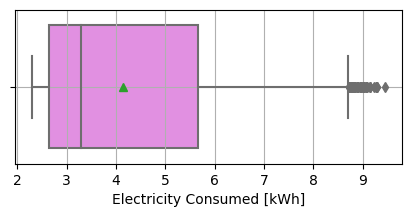

In [0]:
cols=['Electricity Consumed [kWh]']
fig,ax = plt.subplots(figsize=(5,2))
for i in cols:
    sns.boxplot(df1[i],showmeans=True,whis=1.0,color='violet',ax=ax)
    plt.grid()
    plt.show()

In [0]:
df1['Electricity Consumed [kWh]'].describe()

count    35134.000000
mean         4.138484
std          1.800963
min          2.310000
25%          2.640000
50%          3.300000
75%          5.670000
max          9.450000
Name: Electricity Consumed [kWh], dtype: float64

In [0]:
Overall_Consumption_Q1 = df1['Electricity Consumed [kWh]'].quantile(0.25) # Getting First quantile for all numerical variables
Overall_Consumption_Q3 = df1['Electricity Consumed [kWh]'].quantile(0.75) # Getting Second quantile for all numerical variables
Overall_Consumption_IQR = Overall_Consumption_Q3 - Overall_Consumption_Q1          # Getting IQR values
lower_range= Overall_Consumption_Q1-(1.5 * Overall_Consumption_IQR) #Getting Lower Limit for all numerical variables
upper_range= Overall_Consumption_Q3+(1.5 * Overall_Consumption_IQR) #Getting Upper Limit for all numerical variables
print('Overall_Consumption_Q1: 25% of observations recorded is lesser than: ',Overall_Consumption_Q1, 'kWh')
print('Overall_Consumption_Q3: 25% of observations recorded is greater than: ',Overall_Consumption_Q3, 'kWh')
print('Overall_Consumption_IQR: (Q3-Q1)',Overall_Consumption_IQR, 'kWh')
print('lower_range:',lower_range)
print('upper_range:',upper_range)

Overall_Consumption_Q1: 25% of observations recorded is lesser than:  2.64 kWh
Overall_Consumption_Q3: 25% of observations recorded is greater than:  5.67 kWh
Overall_Consumption_IQR: (Q3-Q1) 3.03 kWh
lower_range: -1.9049999999999998
upper_range: 10.215


In [0]:
weekend_df=df1.loc[(df1['weekend'] == 1)]
weekday_df=df1.loc[(df1['weekend'] == 0)]

#set index for further analysis
weekend_df= weekend_df.set_index('Timestamp')
weekday_df=weekday_df.set_index('Timestamp')
df1 = df1.set_index('Timestamp')

/databricks/python/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


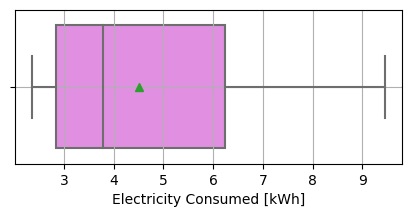

In [0]:
fig,ax = plt.subplots(figsize=(5,2))
for i in cols:
    sns.boxplot(weekday_df[i],showmeans=True,whis=1.0,color='violet',ax=ax)
    plt.grid()
    plt.show()

In [0]:
weekday_df['Electricity Consumed [kWh]'].describe()

count    25054.000000
mean         4.513446
std          1.834341
min          2.370000
25%          2.850000
50%          3.780000
75%          6.240000
max          9.450000
Name: Electricity Consumed [kWh], dtype: float64

In [0]:
Weekday_Consumption_Q1 = weekday_df['Electricity Consumed [kWh]'].quantile(0.25) # Getting First quantile for all numerical variables
Weekday_Consumption_Q3 = weekday_df['Electricity Consumed [kWh]'].quantile(0.75) # Getting Second quantile for all numerical variables
Weekday_Consumption_IQR = Weekday_Consumption_Q3 - Weekday_Consumption_Q1          # Getting IQR values
lower_range= Weekday_Consumption_Q1-(1.5 * Weekday_Consumption_IQR) #Getting Lower Limit for all numerical variables
upper_range= Weekday_Consumption_Q3+(1.5 * Weekday_Consumption_IQR) #Getting Upper Limit for all numerical variables
print('Weekday_Consumption_Q1: 25% of observations recorded is lesser than: ',Weekday_Consumption_Q1, 'kWh')
print('Weekday_Consumption_Q3: 25% of observations recorded is greater than: ',Weekday_Consumption_Q3, 'kWh')
print('Weekday_Consumption_IQR: (Q3-Q1)',Weekday_Consumption_IQR, 'kWh')
print('lower_range:',lower_range)
print('upper_range:',upper_range)

Weekday_Consumption_Q1: 25% of observations recorded is lesser than:  2.85 kWh
Weekday_Consumption_Q3: 25% of observations recorded is greater than:  6.24 kWh
Weekday_Consumption_IQR: (Q3-Q1) 3.39 kWh
lower_range: -2.235
upper_range: 11.325


/databricks/python/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


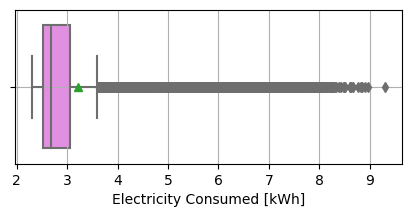

In [0]:
fig,ax = plt.subplots(figsize=(5,2))
for i in cols:
    sns.boxplot(weekend_df[i],showmeans=True,whis=1.0,color='violet',ax=ax)
    plt.grid()
    plt.show()

In [0]:
weekend_df['Electricity Consumed [kWh]'].describe()

count    10080.000000
mean         3.206512
std          1.313023
min          2.310000
25%          2.520000
50%          2.670000
75%          3.060000
max          9.300000
Name: Electricity Consumed [kWh], dtype: float64

In [0]:
Weekend_Consumption_Q1 = weekend_df['Electricity Consumed [kWh]'].quantile(0.25) # Getting First quantile for all numerical variables
Weekend_Consumption_Q3 = weekend_df['Electricity Consumed [kWh]'].quantile(0.75) # Getting Second quantile for all numerical variables
Weekend_Consumption_IQR = (Weekend_Consumption_Q3) - (Weekend_Consumption_Q1)         # Getting IQR values
lower_range= Weekend_Consumption_Q1-(1.5 * Weekend_Consumption_IQR) #Getting Lower Limit for all numerical variables
upper_range= Weekend_Consumption_Q3+(1.5 * Weekend_Consumption_IQR) #Getting Upper Limit for all numerical variables
print('Weekend_Consumption_Q1: 25% of observations recorded is lesser than: ',Weekend_Consumption_Q1, 'kWh')
print('Weekend_Consumption_Q3: 25% of observations recorded is greater than: ',Weekend_Consumption_Q3, 'kWh')
print('Weekend_Consumption_IQR: (Q3-Q1)',Weekend_Consumption_IQR, 'kWh')
print('lower_range:',lower_range)
print('upper_range:',upper_range)

Weekend_Consumption_Q1: 25% of observations recorded is lesser than:  2.52 kWh
Weekend_Consumption_Q3: 25% of observations recorded is greater than:  3.06 kWh
Weekend_Consumption_IQR: (Q3-Q1) 0.54 kWh
lower_range: 1.71
upper_range: 3.87


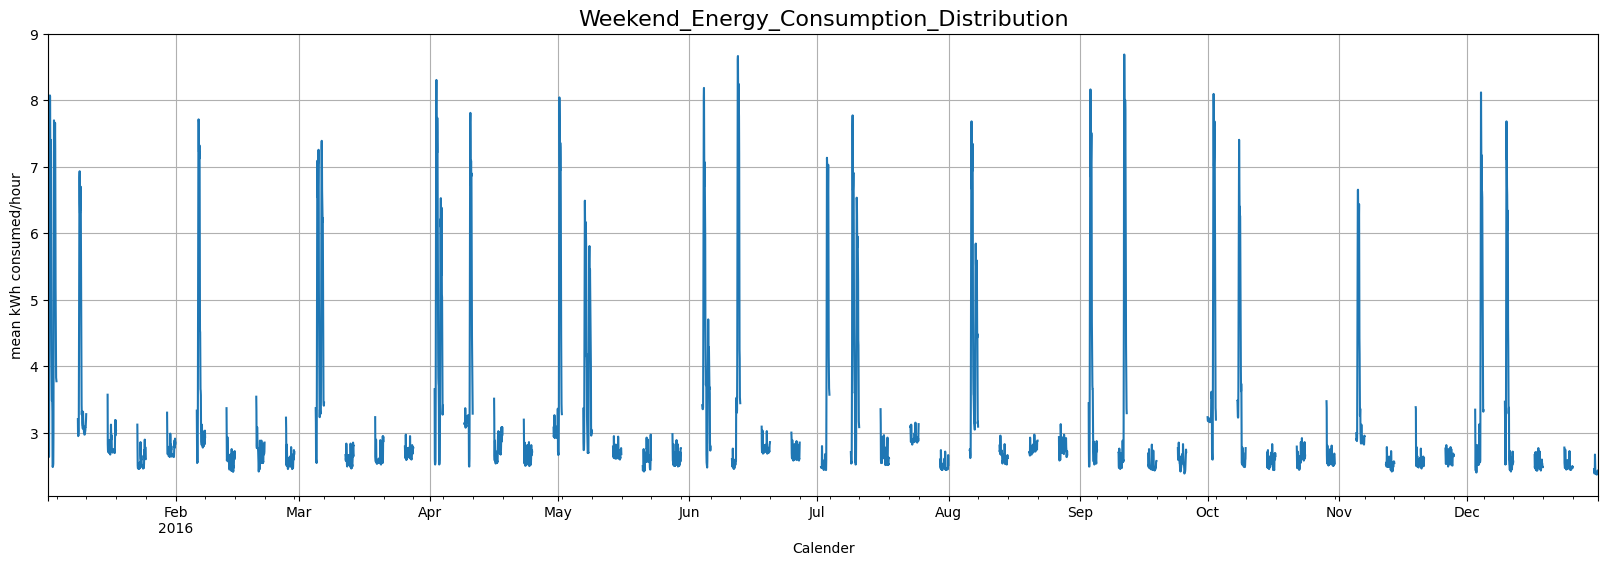

In [0]:
hourly_weekend_df = weekend_df['Electricity Consumed [kWh]'].resample('H').mean()
plt.figure()
weekend_hourly_figure = hourly_weekend_df.plot(figsize=(20,6))
plt.grid()
plt.title('Weekend_Energy_Consumption_Distribution',fontsize = 16)
plt.ylabel('mean kWh consumed/hour')
plt.xlabel('Calender')
plt.show()

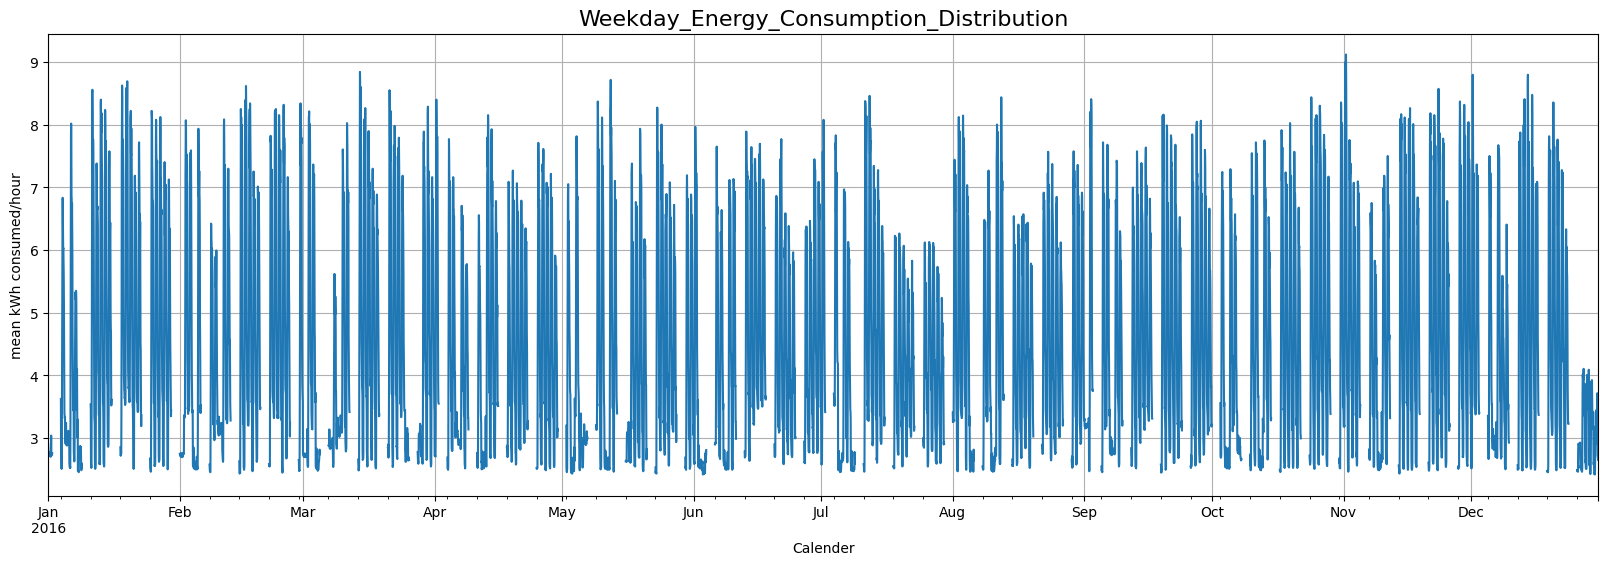

In [0]:
hourly_weekday_df = weekday_df['Electricity Consumed [kWh]'].resample('H').mean()
plt.figure()
weekday_hourly_figure = hourly_weekday_df.plot(figsize=(20,6))
plt.grid()
plt.title('Weekday_Energy_Consumption_Distribution',fontsize = 16)
plt.ylabel('mean kWh consumed/hour')
plt.xlabel('Calender')
plt.show()

In [0]:
# Looking at the overall data distribution, 25% of  energy consumption > 5.67 kWh/every 15 mins.

# Also, there is a clear distinction on "energy consumption" between "weekdays" and "weekends"

# For "weekdays", 25% of energy consumption > 6.24 kWH/every 15 mins (max_value: 9.24 kWh). 

# For "weekends", 25% of energy consumption > 3.06 kWH/every 15 mins (max_value: 9.3 kWh). From "Weekend_Energy_Consumption_Distribution" chart, it is seen that "On first and second weekend of every month, the energy consumption is similar to weekday energy consumption" i.e On these days , It has crossed 75% percentile (of 3.06 kWh) and reached till 9.3 kWh. 

In [0]:
daily_consumption_df = df1['Electricity Consumed [kWh]'].resample('D').mean()
daily_consumption_df.describe()

count    366.000000
mean       4.138485
std        1.030955
min        2.416562
25%        2.835391
50%        4.585625
75%        5.007969
max        5.741875
Name: Electricity Consumed [kWh], dtype: float64

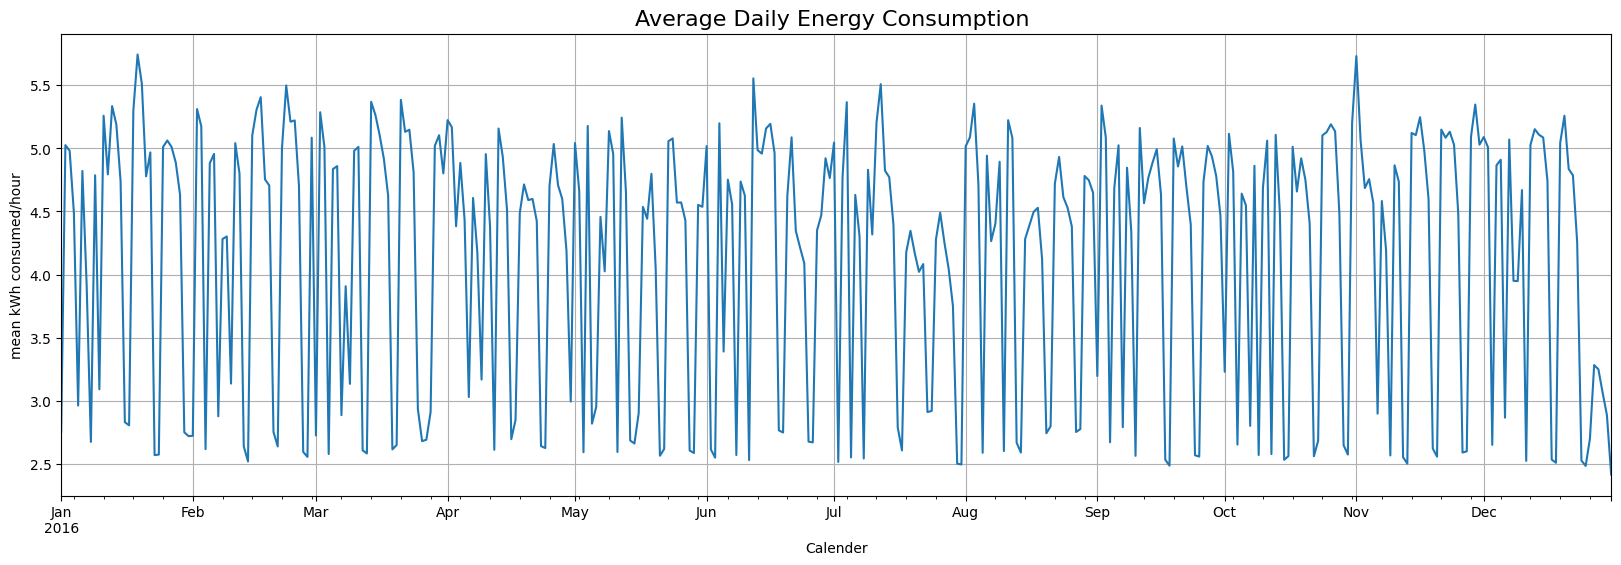

In [0]:
plt.figure()
daily_figure = daily_consumption_df.plot(figsize=(20,6))
plt.title('Average Daily Energy Consumption ',fontsize = 16)
plt.grid()
plt.ylabel('mean kWh consumed/hour')
plt.xlabel('Calender')
plt.show()

In [0]:
monthly_consumption_df = df1['Electricity Consumed [kWh]'].resample('M').mean()
monthly_consumption_df.describe()

count    12.000000
mean      4.139803
std       0.118338
min       3.951240
25%       4.059520
50%       4.175505
75%       4.213186
max       4.314917
Name: Electricity Consumed [kWh], dtype: float64

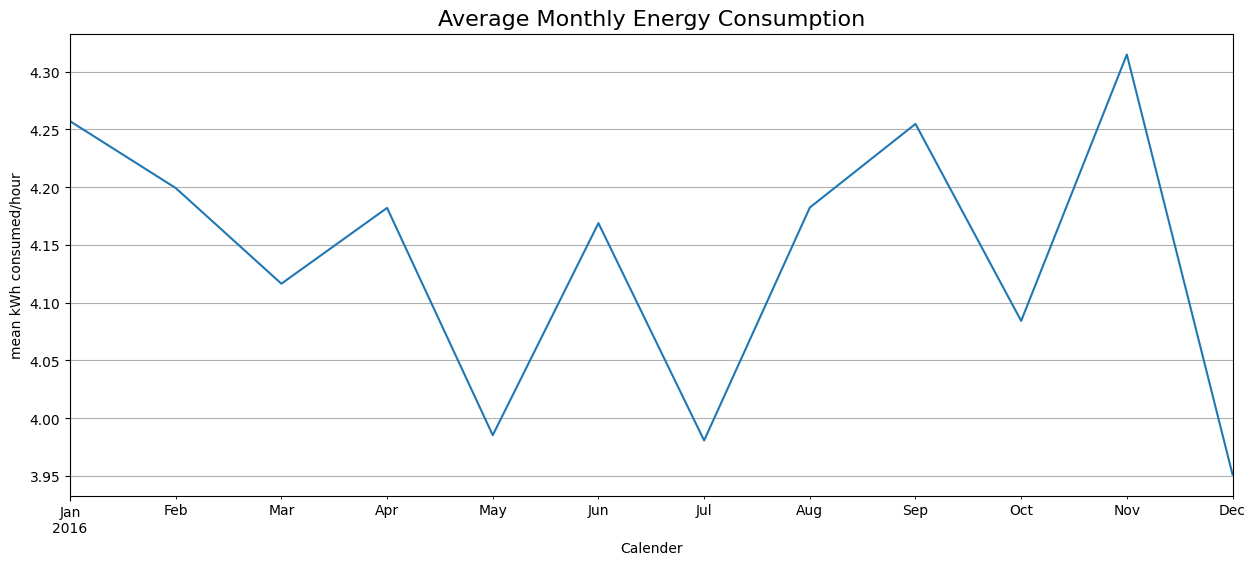

In [0]:
plt.figure()
monthly_figure = monthly_consumption_df.plot(figsize=(15,6))
plt.title('Average Monthly Energy Consumption',fontsize = 16)
plt.grid()
plt.ylabel('mean kWh consumed/hour')
plt.xlabel('Calender')
plt.show()

In [0]:
quarterly_consumption_df = df1['Electricity Consumed [kWh]'].resample('Q').mean()
quarterly_consumption_df.describe()

count    4.000000
mean     4.138561
std      0.036880
min      4.110711
25%      4.113659
50%      4.126349
75%      4.151251
max      4.190833
Name: Electricity Consumed [kWh], dtype: float64

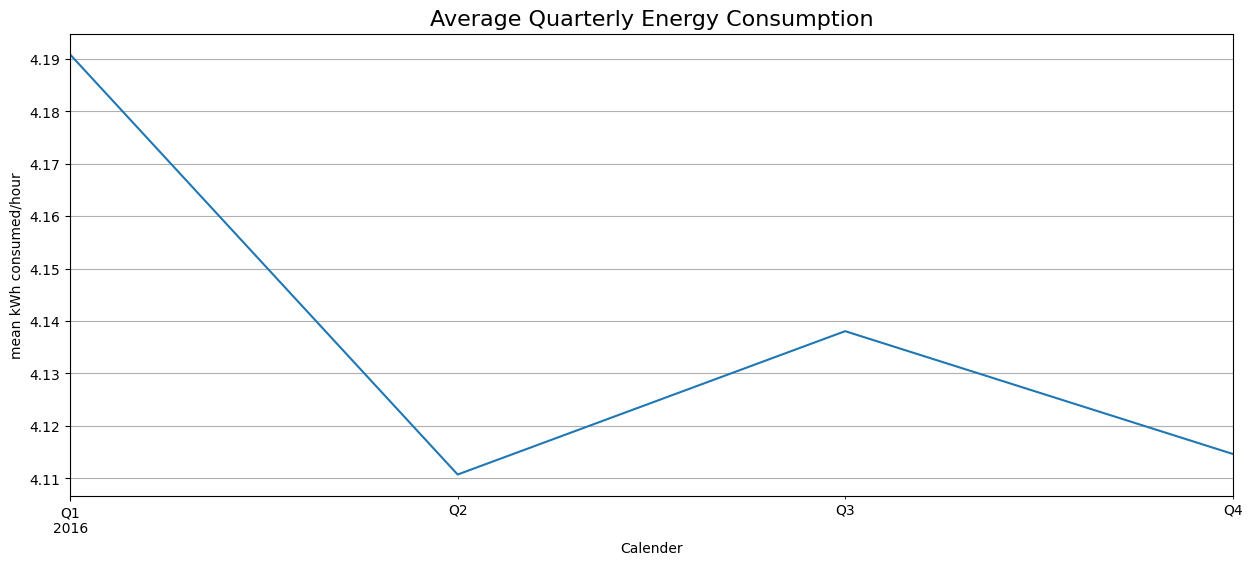

In [0]:
plt.figure()
quarterly_figure = quarterly_consumption_df.plot(figsize=(15,6))
plt.title('Average Quarterly Energy Consumption',fontsize = 16)
plt.ylabel('mean kWh consumed/hour')
plt.xlabel('Calender')
plt.grid()
plt.show()

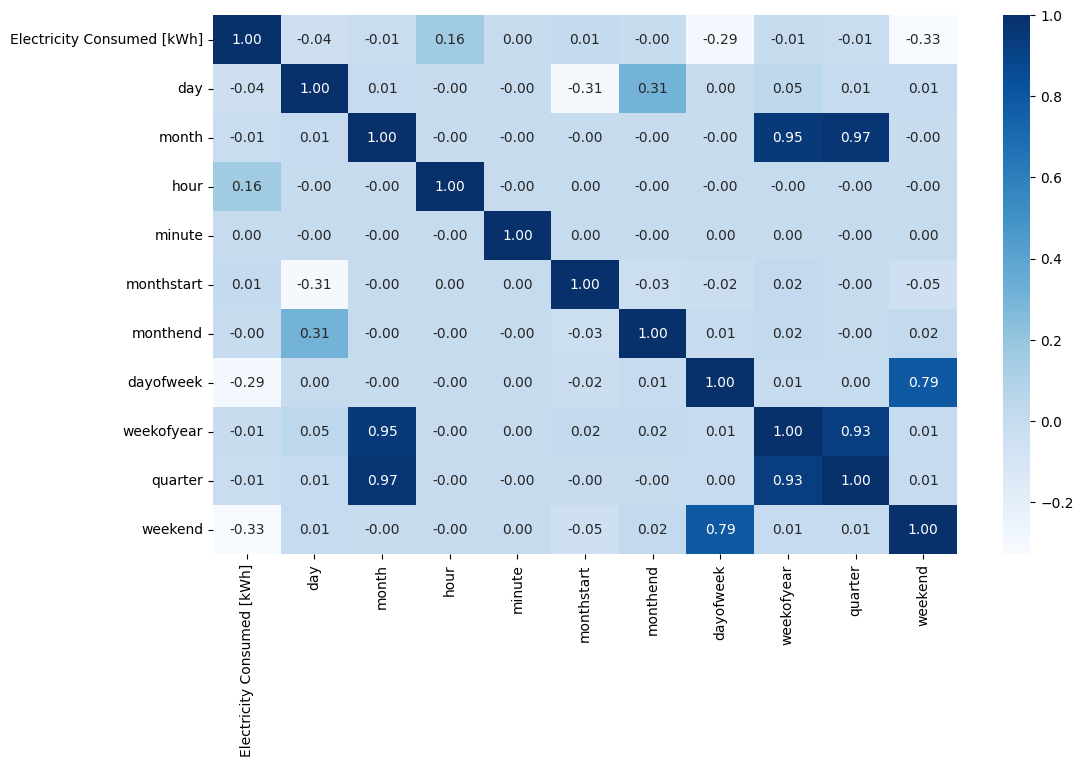

In [0]:
plt.figure(figsize=(12,7))
sns.heatmap(df1.corr(), annot=True, fmt='.2f', cmap='Blues')
plt.show()

In [0]:
# Drop 'Timestamp' : Not needed for Building Model
# Drop 'weekofyear' and 'quarter': These features are in correlation with other features. Hence, Dropping them.

df1 = df1.reset_index('Timestamp')
df1.drop(['quarter','weekofyear'],axis=1,inplace=True)
df1.drop(['Timestamp'],axis=1,inplace=True)
df1.head(5)

,Electricity Consumed [kWh],day,month,hour,minute,monthstart,monthend,dayofweek,weekend
0,2.85,1,1,0,15,1,0,4,0
1,2.85,1,1,0,30,1,0,4,0
2,3.00,1,1,0,45,1,0,4,0
3,2.94,1,1,1,0,1,0,4,0
4,2.79,1,1,1,15,1,0,4,0


In [0]:
    # Copy all the predictor variables into X dataframe
    X = df1.drop(['Electricity Consumed [kWh]'],axis=1) 
    # Copy target into the y dataframe. 
    y = df1[['Electricity Consumed [kWh]']]    
    X.shape,y.shape

((35134, 8), (35134, 1))

In [0]:
from sklearn.model_selection import train_test_split
# splitting data into training and test set for independent attributes
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20 , random_state=1) 

In [0]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler() 
x_train_scaled=ss.fit_transform(x_train)
x_test_scaled=ss.transform(x_test)

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

In [0]:
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor

In [0]:
dtr = tree.DecisionTreeRegressor()
hyper_dtr = tree.DecisionTreeRegressor(max_depth=25,min_samples_leaf=3,min_samples_split=15,random_state=1)
rfr = RandomForestRegressor()

#ann = MLPRegressor(hidden_layer_sizes=(100),random_state=1, max_iter=10000)
ann=MLPRegressor()
lr = LinearRegression()
svm = SVR()
lasso = Lasso()
ridge = Ridge()
knn = KNeighborsRegressor(n_neighbors=2)
hyper_knn = KNeighborsRegressor(metric='manhattan',n_neighbors=2,weights='distance')

In [0]:
models = [dtr,rfr,ann,lr,svm,lasso,ridge,knn,hyper_dtr,hyper_knn]
mae_train=[]
mae_test=[]
mse_train=[]
mse_test=[]
rmse_train=[]
rmse_test=[]
r2_train=[]
r2_test=[]
scores_train=[]
scores_test=[]
time_taken=[]

In [0]:
import time

In [0]:
for i in models:  
#    if (i == dtr) :
    if (i == dtr or i == rfr or i == hyper_dtr) :
        start = time.time()
        i.fit(x_train,y_train)
        pred_train=i.predict(x_train)
        pred_test=i.predict(x_test)
        scores_train.append(i.score(x_train, y_train))
        scores_test.append(i.score(x_test, y_test))
        mae_train.append(mean_absolute_error(y_train,pred_train))
        mae_test.append(mean_absolute_error(y_test,pred_test))
        mse_train.append(mean_squared_error(y_train,pred_train))
        mse_test.append(mean_squared_error(y_test,pred_test))
        rmse_train.append(np.sqrt(mean_squared_error(y_train,pred_train)))
        rmse_test.append(np.sqrt(mean_squared_error(y_test,pred_test)))
        r2_train.append(r2_score(y_train,pred_train))
        r2_test.append(r2_score(y_test,pred_test))
        end = time.time()
        diff = end - start
        time_taken.append(diff)
        print("model that doesn't need scaling: ",i)
        print("time taken: ",diff)       
    else :
        start = time.time() 
        i.fit(x_train_scaled,y_train)
        pred_train_scaled=i.predict(x_train_scaled)
        pred_test_scaled=i.predict(x_test_scaled)
        scores_train.append(i.score(x_train_scaled, y_train))
        scores_test.append(i.score(x_test_scaled, y_test))
        mae_train.append(mean_absolute_error(y_train,pred_train_scaled))
        mae_test.append(mean_absolute_error(y_test,pred_test_scaled))
        mse_train.append(mean_squared_error(y_train,pred_train_scaled))
        mse_test.append(mean_squared_error(y_test,pred_test_scaled))
        rmse_train.append(np.sqrt(mean_squared_error(y_train,pred_train_scaled)))
        rmse_test.append(np.sqrt(mean_squared_error(y_test,pred_test_scaled)))
        r2_train.append(r2_score(y_train,pred_train_scaled))
        r2_test.append(r2_score(y_test,pred_test_scaled))
        end = time.time()
        diff = end - start
        print("model that need scaling: ",i)
        print("time taken: ",diff)
        time_taken.append(diff)

model that doesn't need scaling:  DecisionTreeRegressor()
time taken:  10.993460178375244


/databricks/python_shell/dbruntime/MLWorkloadsInstrumentation/_sklearn.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  original_result = original(self, *args, **kwargs)


model that doesn't need scaling:  RandomForestRegressor()
time taken:  34.70013475418091


/databricks/python/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/databricks/python/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


model that need scaling:  MLPRegressor()
time taken:  80.56951189041138
model that need scaling:  LinearRegression()
time taken:  5.205304145812988


/databricks/python/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


model that need scaling:  SVR()
time taken:  211.66852140426636
model that need scaling:  Lasso()
time taken:  5.100284099578857
model that need scaling:  Ridge()
time taken:  4.871201515197754
model that need scaling:  KNeighborsRegressor(n_neighbors=2)
time taken:  14.336960315704346
model that doesn't need scaling:  DecisionTreeRegressor(max_depth=25, min_samples_leaf=3, min_samples_split=15,
                      random_state=1)
time taken:  5.339143514633179
model that need scaling:  KNeighborsRegressor(metric='manhattan', n_neighbors=2, weights='distance')
time taken:  15.426543712615967


In [0]:
print(pd.DataFrame({'Train RMSE': rmse_train,'Test RMSE': rmse_test,'Train MAE': mae_train,'Test MAE': mae_test,'Train MSE': mse_train,'Test MSE': mse_test,'Training #Score':scores_train,'Test Score': scores_test,'Train R2': r2_train,'Test R2': r2_test,'Time_taken':time_taken},index=['dtr','rfr','ann','lr','svm','lasso','ridge','knn','hyper_dtr','hyper_knn']))

           Train RMSE  Test RMSE  Train MAE  ...  Train R2   Test R2  Time_taken
dtr          0.000179   0.354083   0.000002  ...  1.000000  0.961736   10.993460
rfr          0.097921   0.250681   0.059432  ...  0.997036  0.980821   34.700135
ann          0.800361   0.815839   0.529614  ...  0.801990  0.796861   80.569512
lr           1.670112   1.676681   1.383945  ...  0.137803  0.142004    5.205304
svm          1.034344   1.037505   0.690222  ...  0.669292  0.671478  211.668521
lasso        1.798632   1.810130   1.552902  ...  0.000000 -0.000009    5.100284
ridge        1.670112   1.676681   1.383948  ...  0.137803  0.142004    4.871202
knn          0.319427   0.490404   0.193755  ...  0.968460  0.926601   14.336960
hyper_dtr    0.266773   0.349587   0.156036  ...  0.978001  0.962701    5.339144
hyper_knn    0.000179   0.435563   0.000002  ...  1.000000  0.942099   15.426544

[10 rows x 11 columns]


In [0]:
#param_grid = {
#    'max_depth': [5,10,15,20,25],
#    'min_samples_leaf': [3, 15,30],
#    'min_samples_split': [15,30,35,40,50],
#}

#hyper_dtr=tree.DecisionTreeRegressor(random_state=1)

#grid_search = GridSearchCV(estimator = hyper_dtr, param_grid = param_grid, cv = 5,verbose=1)

#grid_search.fit(x_train,y_train)

#print(grid_search.best_params_)

In [0]:
#param_grid = {
#    'n_neighbors':[2,3,4,5,6,7,8,9,10],
#    'weights' : ['uniform','distance'],
#    'metric' : ['minkowski','euclidean','manhattan'],
#}

#hyper_knn =KNeighborsRegressor()

#grid_search = GridSearchCV(estimator = hyper_knn, param_grid = param_grid, cv = 5,verbose=1)

#grid_search.fit(x_train_scaled,y_train)

#print(grid_search.best_params_)

<Figure size 600x500 with 0 Axes>

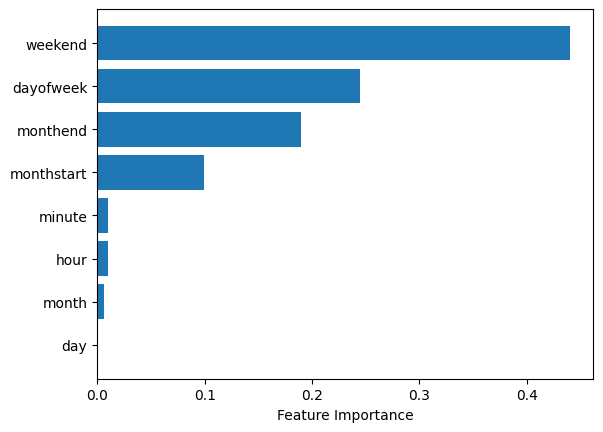

<Figure size 600x500 with 0 Axes>

In [0]:
sorted_idx = dtr.feature_importances_.argsort()
plt.barh(x_train.columns,dtr.feature_importances_[sorted_idx])
plt.xlabel("Feature Importance")
plt.figure(figsize=(6,5))

In [0]:
df2 = pd.read_csv("/dbfs/FileStore/shared_uploads/vijaykailash.sankaranaray@wipro.com/2__Consumable_Energy_Surge_Detection_Data___Validation.csv")
df2.shape

(8606, 2)

In [0]:
df2.head()

,Date Time,Electricity Consumed [kWh]
0,01-01-17 0:00,2.40
1,01-01-17 0:15,2.43
2,01-01-17 0:30,2.43
3,01-01-17 0:45,2.43
4,01-01-17 1:00,2.43


In [0]:
df2.isna().sum()

Date Time                     0
Electricity Consumed [kWh]    0
dtype: int64

In [0]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8606 entries, 0 to 8605
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date Time                   8606 non-null   object 
 1   Electricity Consumed [kWh]  8606 non-null   float64
dtypes: float64(1), object(1)
memory usage: 134.6+ KB


In [0]:
df2['Timestamp']=pd.to_datetime(df2['Date Time'])

In [0]:
df2['day'] = pd.DatetimeIndex(df2['Timestamp']).day
df2['month'] = pd.DatetimeIndex(df2['Timestamp']).month
df2['hour'] = pd.DatetimeIndex(df2['Timestamp']).hour
df2['minute'] = pd.DatetimeIndex(df2['Timestamp']).minute

df2['monthstart'] = pd.DatetimeIndex(df2['Timestamp']).is_month_start
df2['monthend'] = pd.DatetimeIndex(df2['Timestamp']).is_month_end
df2['dayofweek'] = pd.DatetimeIndex(df2['Timestamp']).dayofweek

df2['weekofyear'] = pd.DatetimeIndex(df2['Timestamp']).weekofyear
# https://en.wikipedia.org/wiki/ISO_week_date#First_week
df2['quarter'] = pd.DatetimeIndex(df2['Timestamp']).quarter

<command-1190536555879637>:10: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df2['weekofyear'] = pd.DatetimeIndex(df2['Timestamp']).weekofyear


In [0]:
df2.monthstart = df2.monthstart.replace({True: 1, False: 0})
df2.monthend = df2.monthend.replace({True: 1, False: 0})

In [0]:
# Categorize the energy consumption based on weekday and weekend 
#1 Check for energy consumption on weekday
#2 Check for energy consumption on weekend

In [0]:
df2['weekend']=np.zeros(len(df2))
df2['weekend'] = df2['weekend'].astype('int64')

df2['weekend'][(df2['dayofweek']==5)|(df2['dayofweek']==6)]=1

<command-1190536555879507>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['weekend'][(df2['dayofweek']==5)|(df2['dayofweek']==6)]=1


In [0]:
#for date,name in sorted(holidays.IND(years=2017).items()):
#   print(date,name)

In [0]:
validation_file_backup = df2[['Date Time','Electricity Consumed [kWh]','weekend']]
validation_actual_energy=validation_file_backup['Electricity Consumed [kWh]']
validation_file_backup

,Date Time,Electricity Consumed [kWh],weekend
0,01-01-17 0:00,2.40,1
1,01-01-17 0:15,2.43,1
2,01-01-17 0:30,2.43,1
3,01-01-17 0:45,2.43,1
4,01-01-17 1:00,2.43,1
...,...,...,...
8601,31-03-17 22:45,3.09,0
8602,31-03-17 23:00,3.06,0
8603,31-03-17 23:15,3.12,0
8604,31-03-17 23:30,3.00,0


In [0]:
df2

,Date Time,Electricity Consumed [kWh],Timestamp,day,month,hour,minute,monthstart,monthend,dayofweek,weekofyear,quarter,weekend
0,01-01-17 0:00,2.40,2017-01-01 00:00:00,1,1,0,0,1,0,6,52,1,1
1,01-01-17 0:15,2.43,2017-01-01 00:15:00,1,1,0,15,1,0,6,52,1,1
2,01-01-17 0:30,2.43,2017-01-01 00:30:00,1,1,0,30,1,0,6,52,1,1
3,01-01-17 0:45,2.43,2017-01-01 00:45:00,1,1,0,45,1,0,6,52,1,1
4,01-01-17 1:00,2.43,2017-01-01 01:00:00,1,1,1,0,1,0,6,52,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8601,31-03-17 22:45,3.09,2017-03-31 22:45:00,31,3,22,45,0,1,4,13,1,0
8602,31-03-17 23:00,3.06,2017-03-31 23:00:00,31,3,23,0,0,1,4,13,1,0
8603,31-03-17 23:15,3.12,2017-03-31 23:15:00,31,3,23,15,0,1,4,13,1,0
8604,31-03-17 23:30,3.00,2017-03-31 23:30:00,31,3,23,30,0,1,4,13,1,0


In [0]:
#df1 = df1.set_index('Date/Time')

df2.drop(['Date Time'],axis=1,inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8606 entries, 0 to 8605
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Electricity Consumed [kWh]  8606 non-null   float64       
 1   Timestamp                   8606 non-null   datetime64[ns]
 2   day                         8606 non-null   int64         
 3   month                       8606 non-null   int64         
 4   hour                        8606 non-null   int64         
 5   minute                      8606 non-null   int64         
 6   monthstart                  8606 non-null   int64         
 7   monthend                    8606 non-null   int64         
 8   dayofweek                   8606 non-null   int64         
 9   weekofyear                  8606 non-null   int64         
 10  quarter                     8606 non-null   int64         
 11  weekend                     8606 non-null   int64       

In [0]:
df2.drop(['Timestamp','Electricity Consumed [kWh]'],axis=1,inplace=True)
df2.drop(['weekofyear','quarter'],axis=1,inplace=True)
df2

,day,month,hour,minute,monthstart,monthend,dayofweek,weekend
0,1,1,0,0,1,0,6,1
1,1,1,0,15,1,0,6,1
2,1,1,0,30,1,0,6,1
3,1,1,0,45,1,0,6,1
4,1,1,1,0,1,0,6,1
...,...,...,...,...,...,...,...,...
8601,31,3,22,45,0,1,4,0
8602,31,3,23,0,0,1,4,0
8603,31,3,23,15,0,1,4,0
8604,31,3,23,30,0,1,4,0


In [0]:
ss=StandardScaler() 
x_scaled=ss.fit_transform(X)
df2_scaled=ss.transform(df2)

In [0]:
## Based on Model Performance in the Training phase, Predict using the chosen model on the Validation Dataframe
models_validation = [hyper_dtr]

In [0]:
mae_validation=[]
mse_validation=[]
rmse_validation=[]
scores_validation=[]

In [0]:
for i in models_validation: 
    if ( i == hyper_dtr or i == dtr or i == rfr) :
        start = time.time()
        i.fit(X,y)
        pred_test=i.predict(df2)
        mae_validation.append(mean_absolute_error(validation_actual_energy,pred_test))
        mse_validation.append(mean_squared_error(validation_actual_energy,pred_test))
        rmse_validation.append(np.sqrt(mean_squared_error(validation_actual_energy,pred_test)))
        end = time.time()
        diff = end - start
        print("model : ",i)
        print("time taken: ",diff)       
    else :
        start = time.time() 
        i.fit(x_scaled,y)
        pred_test_scaled=i.predict(df2_scaled)
        mae_validation.append(mean_absolute_error(validation_actual_energy,pred_test_scaled))
        mse_validation.append(mean_squared_error(validation_actual_energy,pred_test_scaled))
        rmse_validation.append(np.sqrt(mean_squared_error(validation_actual_energy,pred_test_scaled)))
        end = time.time()
        diff = end - start
        print("model on scaled df: ",i)
        print("time taken: ",diff)

model :  DecisionTreeRegressor(max_depth=25, min_samples_leaf=3, min_samples_split=15,
                      random_state=1)
time taken:  3.719778299331665


In [0]:
print(pd.DataFrame({'Validation RMSE': rmse_validation,'Validation MAE': mae_validation,'Validation MSE': mse_validation},
            index=['hyper_dtr']))

           Validation RMSE  Validation MAE  Validation MSE
hyper_dtr         1.432302        0.769758        2.051489


In [0]:
predicted_hyper_dtr= hyper_dtr.predict(df2)
df_predicted_file_energy  = pd.DataFrame(predicted_hyper_dtr, columns =['Prediction_Energy_Consumption']) 

Text(0.5, 0, 'Calender')

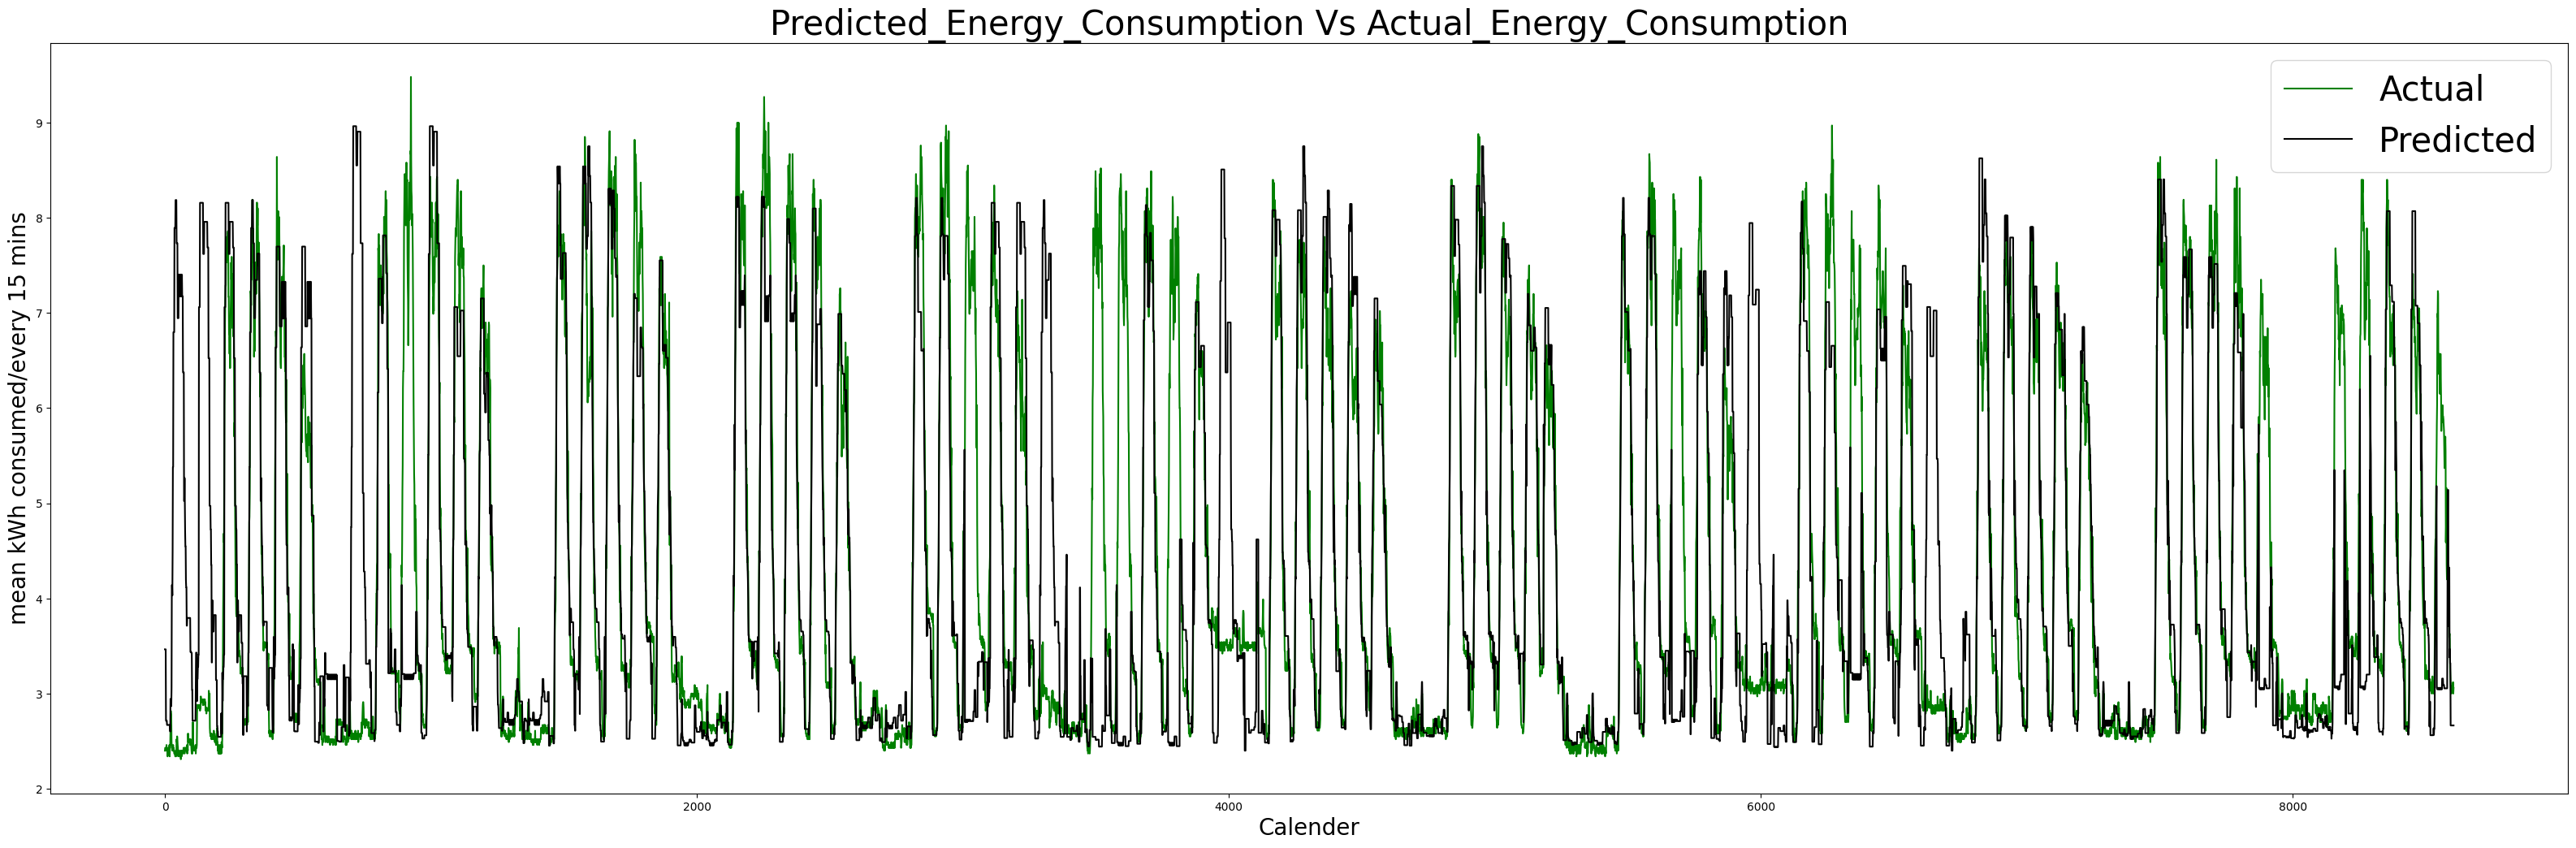

In [0]:
fig = plt.figure(figsize=(40,12))
plt.plot(df2.index, validation_actual_energy, label='Actual', color='g')
plt.plot(df2.index, predicted_hyper_dtr, label='Predicted', color='k')
plt.legend(loc='upper right',fontsize="30")
plt.title('Predicted_Energy_Consumption Vs Actual_Energy_Consumption',fontsize = 30)
plt.ylabel('mean kWh consumed/every 15 mins',fontsize = 20)
plt.xlabel('Calender',fontsize = 20)

In [0]:
df_result=pd.concat([validation_file_backup.reset_index(drop=True),df_predicted_file_energy.reset_index(drop=True)],axis=1)

In addition to Forecasting "Energy Consumption", Generate Label "Forecast Energy Consumption Category" in the resultant dataframe.

In [0]:
df_result['Forecast_consumption_category']=np.zeros(len(df_result))
df_result['Forecast_consumption_category'] = df_result['Forecast_consumption_category'].astype('object')

# For Weekdays

df_result['Forecast_consumption_category']=np.where((df_result['Prediction_Energy_Consumption'] < Weekday_Consumption_Q3) & (df_result['weekend'] == 0), 'Standard Consumption' ,df_result['Forecast_consumption_category'])

df_result['Forecast_consumption_category']=np.where((df_result['Prediction_Energy_Consumption'] >= Weekday_Consumption_Q3) & (df_result['weekend'] == 0), 'Anamalous Consumption' ,df_result['Forecast_consumption_category'])

# For Weekends

df_result['Forecast_consumption_category']=np.where((df_result['Prediction_Energy_Consumption'] < Weekend_Consumption_Q3) & (df_result['weekend'] == 1), 'Standard Consumption',df_result['Forecast_consumption_category'])

df_result['Forecast_consumption_category']=np.where((df_result['Prediction_Energy_Consumption'] >= Weekend_Consumption_Q3) & (df_result['weekend'] == 1), 'Anamalous Consumption' ,df_result['Forecast_consumption_category'])

In [0]:
df_result.drop(['weekend'],axis=1,inplace=True)

In [0]:
df_result.to_csv("/Workspace/Users/vijaykailash.sankaranaray@wipro.com/result_regression_anamalous_consumption.csv",index=False)

**End**